In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.stats import spearmanr, pearsonr, entropy
import libpysal
from esda.moran import Moran

import torch
import torch.nn as nn
import torch.optim as optim

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/NN_Stabilization/venv/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
data = load_wine()
target = load_wine().target
df = pd.DataFrame(data.data, columns=data.feature_names)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
num_epochs = 1000
batch_size = 16
dataset = torch.tensor(df_scaled, dtype=torch.float32)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
input_dim = df.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/ademidemabadeje/Documents/UT/Research/PyCharm/NN_Stabilization/venv/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


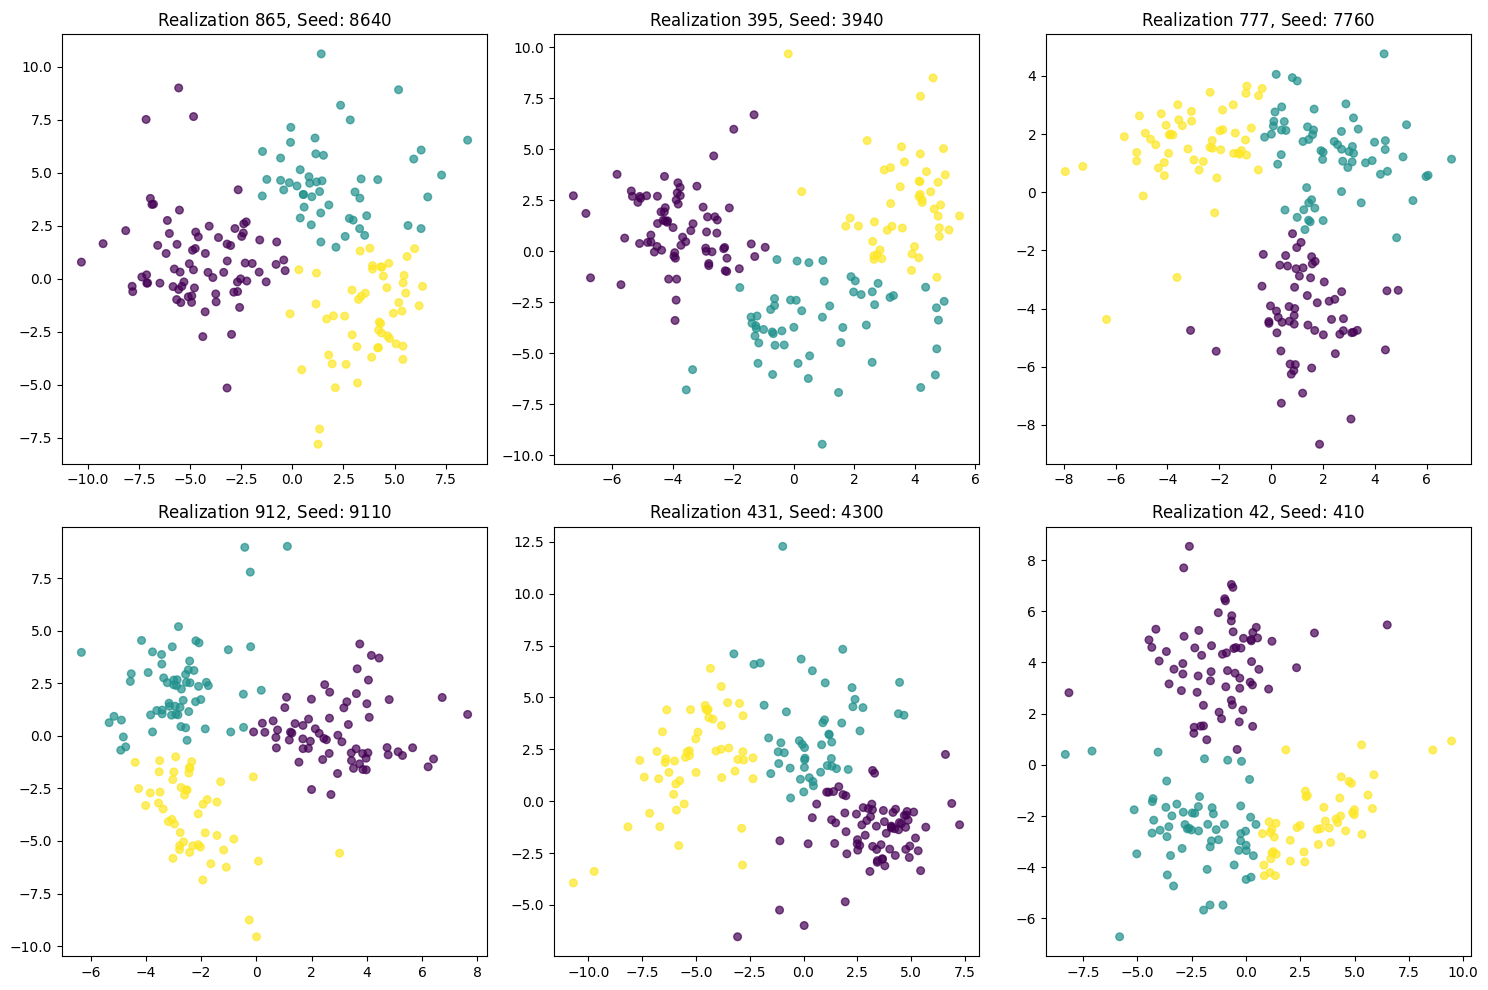

In [6]:
initial_seed = 0 # starting sequence for random seed generator
step_size = 10   # Change this to increase seeds every x units
random.seed(initial_seed)
num_seeds = 1000 # nos of realizations needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)]
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments
statistics_array = np.empty((num_seeds, 7))
pvalues_array = np.empty((num_seeds, 3))
all_loss_curves = []

# Create a 3x3 grid for visualizations
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

change_percentages = []  # List to store percentage of changed clusters for each realization

# Randomly select 6 realizations for visualization
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)


#     # Clustering in latent space
#     Here's a breakdown of how it works:
#
# 1. **Initialization**:
#    - `cluster_changes` is initialized as a zero array with the same shape as the `target` (truth labels). This means initially, all data points have 0 changes.
#    - `predicted_clusters` is computed for each realization after clustering in the latent space.
#
# 2. **Matching clusters with truth labels**:
#    - A cost matrix is computed to find the best correspondence between predicted clusters and the true labels.
#    - The Hungarian algorithm (`linear_sum_assignment`) is used to determine the optimal assignment.
#    - After the best assignment is determined, `predicted_clusters` labels are rearranged to match the true labels as closely as possible.
#
# 3. **Tracking changes**:
#    - For each data point, if its assigned cluster (`predicted_clusters`) doesn't match its true label (`target`), its corresponding value in `cluster_changes` is incremented by 1.
#    - This process is repeated for all realizations.


    with torch.no_grad():
        encoded_data = model.encoder(dataset).numpy()

    kmeans = KMeans(n_clusters=3, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(3)]
                             for true_indices in [np.where(target == i)[0] for i in range(3)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(3):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(3):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    # Compute the chaos, global, and spatial statistics for each of the latent spaces for each AE realizations
    # Chaos Statistics
    array_flat = encoded_data.flatten()
    values, counts = np.unique(array_flat, return_counts=True)
    probabilities = counts / counts.sum()
    entropy_values = entropy(probabilities, base=2) # s1

    # Global Statistics
    mean_global = np.mean(encoded_data) # s2
    variance_global = np.var(encoded_data) # s3
    norm_fro = np.linalg.norm(encoded_data, 'fro') # s4
    # pearson2 = np.corrcoef(encoded_data[:, 0], encoded_data[:, 1])[0,1]
    pearson, coef_pval = pearsonr(encoded_data[:,0], encoded_data[:,1]) # s5
    spearman, rank_pval = spearmanr(encoded_data[:,0], encoded_data[:,1]) # s6

    # Spatial Statistics
    weights = libpysal.weights.lat2W(encoded_data.shape[0],encoded_data.shape[1], rook=False, id_type="float")
    np.random.seed(seed)

    mi = Moran(encoded_data, weights) # two_tailed=False for one tailed Moran
    moran = mi.I # s7
    moran_pval = mi.p_norm

    # Store the computed statistics in the array for this iteration
    statistics_array[idx, :] = [entropy_values, mean_global, variance_global, norm_fro, pearson, spearman, moran]
    pvalues_array[idx, :] = [coef_pval, rank_pval, moran_pval]

    # Save statistics and pvalues array to numpy files
    np.save('statistics_array.npy', statistics_array)
    np.save('pvalues_array.npy', pvalues_array)

    # Check if the current realization index is in the list of visualization_indices
    if idx in visualization_indices:
        # Visualization of latent space in 3x3 grid
        axs[visualization_indices.index(idx)].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30,
                      alpha=0.7)
        axs[visualization_indices.index(idx)].set_title(f"Realization {idx + 1}, Seed: ${seed}$")

plt.tight_layout()
plt.show()

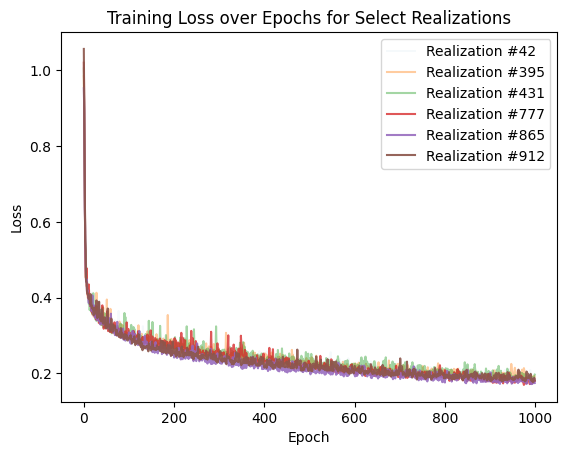

In [20]:
# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization #{idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for Select Realizations')
plt.legend()
plt.show()

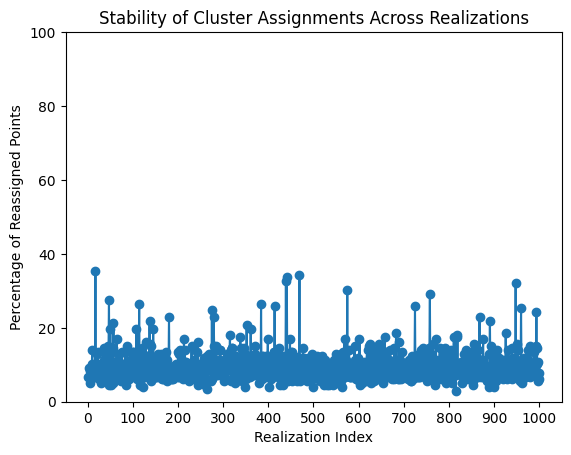

In [13]:
# Analyzing changes in cluster assignments using a line plot i.e., instability plot
plt.figure()
plt.plot(range(1, num_seeds+1), change_percentages, '-o')
plt.xlabel('Realization Index')
plt.ylabel('Percentage of Reassigned Points')
plt.title('Stability of Cluster Assignments Across Realizations')
plt.xticks(np.arange(0, num_seeds+1, 100))
plt.ylim([0, 100])  # y-axis limits between 0 and 100 for percentages
plt.show()

In [19]:
arr_changes = np.array(change_percentages)
sorted_data = np.sort(arr_changes)

# Calculate the 5-point statistic
minimum = np.min(sorted_data)
maximum = np.max(sorted_data)
median = np.median(sorted_data)
q1 = np.percentile(sorted_data, 25)
q3 = np.percentile(sorted_data, 75)
variance = np.var(sorted_data)

# Display the five-number summary
print("Minimum:", round(minimum, 5))
print("First Quartile (Q1):", round(q1, 5))
print("Median (Q2):", round(median, 5))
print("Third Quartile (Q3):", round(q3, 5))
print("Maximum:", round(maximum, 5))
print("Variance:", round(variance, 5))

Minimum: 2.80899
First Quartile (Q1): 7.30337
Median (Q2): 8.98876
Third Quartile (Q3): 11.23596
Maximum: 35.39326
Variance: 14.82796


**Recall in each realization, we do the following:**

1. Train an autoencoder, and then applying k-means to the latent space to identify clusters.
2. These clusters are then matched to the true labels to minimize the discrepancies between predicted and true cluster assignments.
3. After matching, for each data point, if the matched predicted cluster is different from its true label, it's considered a "change", and the corresponding entry in `cluster_changes` is incremented.

The `cluster_changes` array accumulates these "changes" for each data point over all realizations. After all realizations are done, the value for a data point in `cluster_changes` represents how many times (out of all realizations) the predicted cluster for that data point didn't match its true label. This becomes a tell-tale sign of stability in the latent feature space.

The introduction of stochastic uncertainty through changing the random seed is a way to account for and analyze the variability in model training and performance. By training a model multiple times with different seeds, you can assess the robustness of the model and gain insights into how sensitive it is to variations in initialization and training data presentation. It helps in understanding the model's generalization and can be useful for hyperparameter tuning and model evaluation.


**Advantages of Minibatch Training for Small Datasets:**

1. Regularization: Minibatch training introduces noise into the training process, which can act as a form of regularization. This can help prevent overfitting, even on small datasets.
2. Efficiency: Minibatch training allows you to take advantage of parallelism, such as using GPUs, which can significantly speed up training even for small datasets.
3. Convergence: Minibatch training can lead to faster convergence, which means your model reaches a good solution more quickly.
4. Memory Efficiency: Training on the full dataset might not fit into memory, especially when the dataset is very large. Minibatch training allows you to work with smaller portions of the data at a time.

**Considerations for Minibatch Training on Small Datasets:**

1. Batch Size: When working with a small dataset, you should carefully choose the batch size. Very small batch sizes can introduce high variance in gradient updates, while very large batch sizes may not provide the regularization benefits of minibatch training. You may need to experiment to find the optimal batch size for your specific dataset and model.
2. Learning Rate: Smaller batch sizes may require smaller learning rates to prevent overshooting during optimization. Again, hyperparameter tuning may be necessary.
3. Validation Set: With a small dataset, it's crucial to have a validation set to monitor model performance. Overfitting can still occur, especially if your model has many parameters.
4. Data Augmentation: Data augmentation techniques (e.g., flipping, rotating, cropping) can help artificially increase the effective size of your dataset, making minibatch training more effective.
5. Transfer Learning: If your small dataset is similar to a larger dataset, you can consider using pre-trained models and fine-tuning them on your dataset.
6. In summary, while minibatch training can be beneficial for small datasets, it requires careful consideration of batch size, learning rate, and other hyperparameters. Additionally, techniques like data augmentation and transfer learning can be used to make the most of small datasets. Ultimately, the choice of whether to use minibatch training or not depends on the specific problem and constraints you are dealing with
